In [2]:
import os
import yaml
import pickle
import matplotlib
from multiprocessing import Pool
from typing import Dict, List, Tuple, Union
from numbers import Number

import torch
import numpy as np
import matplotlib.pyplot as plt
import bilby
import torch
import pandas as pd
import pycbc.psd
from scipy.signal import tukey
from pprint import pprint
from bilby.gw.conversion import (
    convert_to_lal_binary_black_hole_parameters,
    bilby_to_lalsimulation_spins,
)
from pprint import pprint
import lalinference.imrtgr.nrutils as nrutils
import lal
from gwpy.timeseries import TimeSeries
import scipy

import lalsimulation as LS


matplotlib.use('pdf')
os.environ['MPLCONFIGDIR'] = '/home/local/nihargupte'
import dingo.gw.dataset.generate_dataset 
from dingo.gw.inference import injection
import dingo.gw.training.train_builders
import dingo.gw.waveform_generator as waveform_generator
from dingo.gw.waveform_generator import wfg_utils
from dingo.gw.ASD_dataset.noise_dataset import ASDDataset
from dingo.gw.dataset import WaveformDataset
from dingo.gw.domains import build_domain, build_domain_from_model_metadata
import dingo.gw.inference
from dingo.gw.transforms import SelectStandardizeRepackageParameters, RepackageStrainsAndASDS, UnpackDict, SampleExtrinsicParameters, GNPECoalescenceTimes, AddWhiteNoiseComplex
from dingo.core.models import PosteriorModel
import dingo.gw.domains
from dingo.gw.gwutils import get_mismatch
from dingo.gw.waveform_generator import WaveformGenerator, waveform_generator
from dingo.gw.inference.gw_samplers import GWSamplerGNPE, GWSampler

%load_ext autoreload
%autoreload 2
%matplotlib inline

/data/nihargupte/projects/dingo-devel/tgr_venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
charizard_hex = ('#cd5241', '#084152', '#207394', '#eeb45a', '#e64110', '#ff524a', '#f6a410', '#08398b', '#626262', '#833118', '#eede7b')
plt.rcParams['text.usetex'] = False
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=charizard_hex)

In [4]:
# Set theta_jn = 0 to get rid of all higher modes
parameters = {
    "phase": 4.7,
    "mass_1": 38.9, # Solar Masses
    "mass_2": 31.9, # Solar Masses
    "f_ref": 20., # Hz
    "phase": 0.5,
    "chi_1": 0.2,
    "chi_2": 0.2,
    "theta_jn": 0.3,
    "luminosity_distance": 440., #Mpc
    "domega220": 0.,
    "dtau220": 0
}
domain_dict = {
    "type": "FrequencyDomain",
    "f_min": 20.0,
    "f_max": 2048.0,
    "delta_f": 0.125,
}

# Settings the phase shift 
phase_shift = parameters["phase"]
ref_parameters = parameters.copy()
parameters["phase"] = 0

domain = build_domain(domain_dict)

wfg = WaveformGenerator(
    "SEOBNRv4HM_PA",
    domain,
    f_ref=20.0,
    spin_conversion_phase=0.0,
)

Setting spin_conversion_phase = 0.0. Using this value for the phase parameter for conversion to cartesian spins.


Check That ChooseTDWaveform gives the same result as Summing the Modes
----------------------------------------------------------------------

SimInspiralChooseTDWaveform shape (3312,)  vs SimIMRSpinAlignedEOBModes shape (3312,)
Mismatch of [0.0, -2.220446049250313e-16]


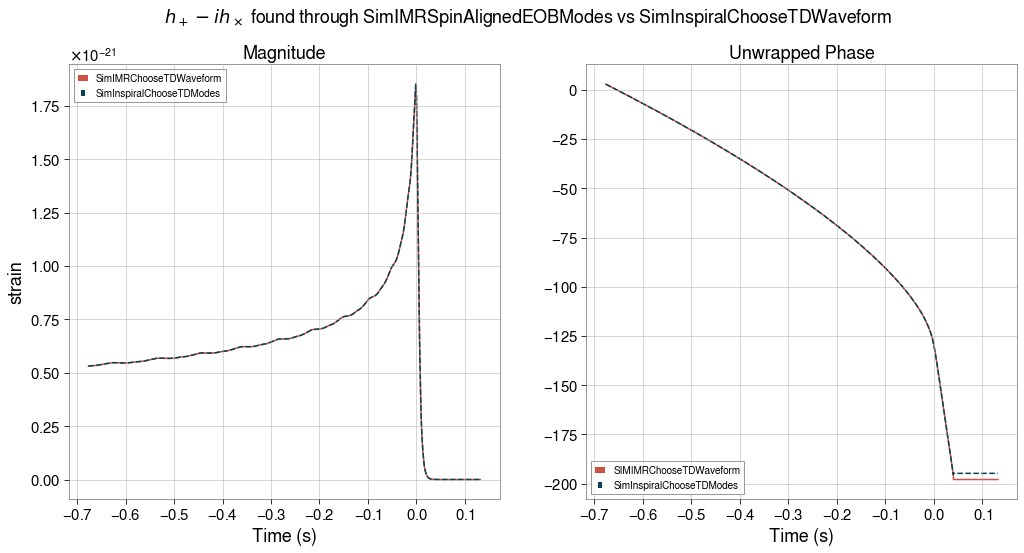

In [5]:
# Getting the WF through SimInspiralChooseTDWaveform
# This is the reference waveform
lal_params = waveform_generator.SEOBNRv4HM_qnm_lal_dict(parameters)
parameters_lal = wfg._convert_parameters_to_lal_frame(parameters, lal_params, lal_target_function="SimInspiralTD")
delta_t = parameters_lal[-5]
hp, hc = LS.SimInspiralChooseTDWaveform(*parameters_lal)
pol_ref = {"h_plus": hp.data.data, "h_cross": hc.data.data}
strain = pol_ref["h_plus"] - 1j*pol_ref["h_cross"]

# Getting the WF through SimIMRSpinAlignedEOBModes 
# This is what we want to match the reference waveform
hlm_td, iota = wfg.generate_TD_modes_L0(parameters)
pol_m = wfg_utils.get_polarizations_from_td_modes_m(hlm_td, iota, parameters["phase"])
# Converting the values in pol_m to numpy arrays, usually it is stored as a LAL object since eventually it will be FFTed but here we just want to compare TD waveform
pol_m = {(l,m):{k:v.data.data for k, v in pol.items()} for (l, m), pol in pol_m.items()}
pol = waveform_generator.sum_contributions_lm(pol_m)

mode_strain = pol["h_plus"] - 1j*pol["h_cross"]

# mode_strain = np.sum(np.array([v.data.data * lal.SpinWeightedSphericalHarmonic(iota, parameters["phase"], -2, ell, m) for (ell, m), v in hlm_td.items()]), axis=0)
print(f"SimInspiralChooseTDWaveform shape {strain.shape}  vs SimIMRSpinAlignedEOBModes shape {mode_strain.shape}")

times = np.arange(0, strain.shape[0]*delta_t, delta_t) + hp.epoch

fig, axes = plt.subplots(1, 2, figsize=(17, 8))
fig.suptitle(r"$h_+ - i h_\times$ found through SimIMRSpinAlignedEOBModes vs SimInspiralChooseTDWaveform")

axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("strain")
# Plotting magnitude
axes[0].set_title("Magnitude")
axes[0].plot(times, np.abs(strain), label=r'SimIMRChooseTDWaveform')
axes[0].plot(times, np.abs(mode_strain), linestyle='--', label=r'SimInspiralChooseTDModes')
axes[0].legend(loc='upper left')

# Plotting phase
# NOTE I'm not actually a 100% sure what that weird offset is past 0.7 seconds, it is exactly pi? But it happens after the waveform is already dead so not 
# sure if it even matters
axes[1].set_title("Unwrapped Phase")
axes[1].set_xlabel("Time (s)")
axes[1].plot(times, np.unwrap(np.angle(strain)), label=r'SIMIMRChooseTDWaveform')
axes[1].plot(times, np.unwrap(np.angle(mode_strain)), linestyle='--', label=r'SimInspiralChooseTDModes')
axes[1].legend(loc='lower left')

mismatches = [get_mismatch(pol[pol_name], pol_ref[pol_name], wfg.domain) for pol_name in pol]
print(f"Mismatch of {mismatches}")

Check that SimInspiralTD is giving the same results as summing the modes and applying transforms
------------------------------------------------------------------------------------------------

Mismatch of [3.893552147360424e-13, 4.001243780749064e-13]


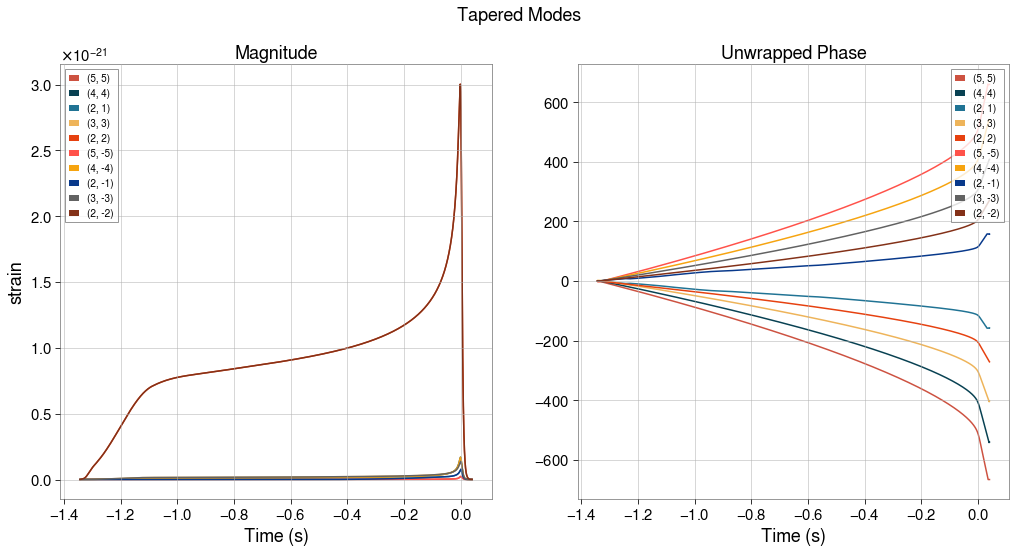

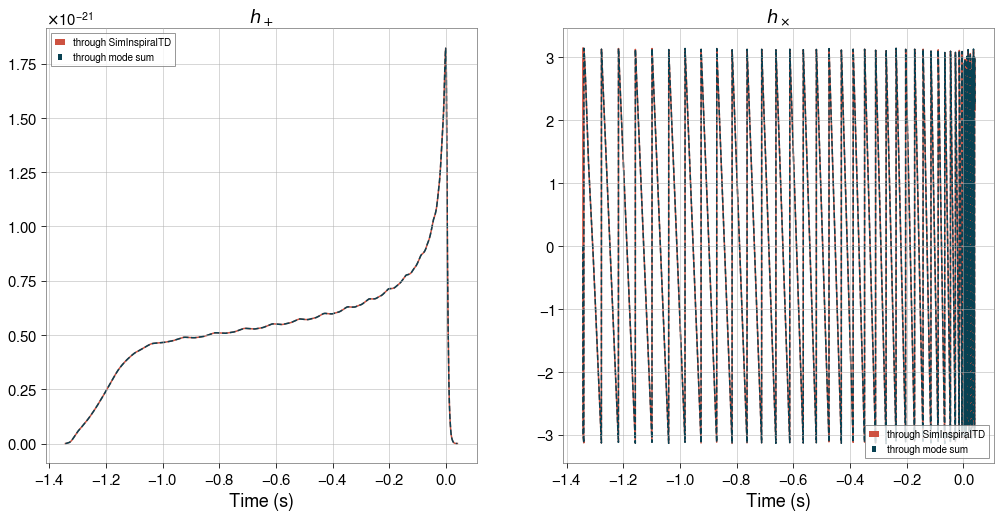

In [6]:
# Creating modes at different f_start
parameters_lal, iota = wfg._convert_parameters_to_lal_frame({**parameters, "f_ref": 20},lal_target_function="SimIMRSpinAlignedEOBModes")
parameters_lal = list(parameters_lal)
f_start, extra_time_fraction, t_chirp, t_extra = wfg_utils.get_aligned_spin_f_start(domain.f_min, parameters_lal[1], parameters_lal[2], parameters_lal[5], parameters_lal[6])
parameters_lal[3] = f_start

# Note this only gives the (l, m) and we need to find the (l, -m) by noting that h_lm = (-1)**l h*_{l-m}
hlm_td, low_samp_dynamics, high_samp_dynamics = LS.SimIMRSpinAlignedEOBModes(*parameters_lal)
hlm_td = wfg_utils.linked_list_modes_to_dict_modes(hlm_td)
for (ell, m), hlm in hlm_td.items():
    h_plus, h_cross = wfg_utils.correct_for_eob_lal_frame_rotation(hlm.data.data.real, -hlm.data.data.imag)
    hlm_td[(ell, m)].data.data = h_plus - 1j*h_cross
wfg_utils.get_aligned_spin_negative_modes_in_place(hlm_td)

times = wfg_utils.taper_aligned_spin_td_modes_in_place(hlm_td, parameters_lal[1], parameters_lal[2], extra_time_fraction, t_chirp, t_extra, domain.f_min)

# Technically we don't the rest but we want to make sure we get the same tapering as SimInspiralTD
pol_m = wfg_utils.get_polarizations_from_td_modes_m(hlm_td, iota, parameters["phase"])
pol_m = {(l,m):{k:v.data.data for k, v in pol.items()} for (l, m), pol in pol_m.items()}
pol = waveform_generator.sum_contributions_lm(pol_m)

# Shouldn't the positive frequencies be non-zero not the negative frequencies??
# Converting to frequency domain
fig, axes = plt.subplots(1, 2, figsize=(17, 8))
fig.suptitle("Tapered Modes")

axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("strain")
axes[0].set_title("Magnitude")

for (ell, m), td in hlm_td.items():
    axes[0].plot(times, np.abs(td.data.data), label=f"({ell}, {m})")
    axes[1].plot(times, np.unwrap(np.angle(td.data.data)), label=f"({ell}, {m})")

axes[0].legend()
axes[1].set_title("Unwrapped Phase")
axes[1].set_xlabel("Time (s)")

axes[1].legend(loc='upper right')


# SimInspiralTD already does the conditioning
fig, axes = plt.subplots(1, 2, figsize=(17, 8))

p = wfg._convert_parameters_to_lal_frame(parameters, lal_params, lal_target_function="SimInspiralTD")
hp, hc = LS.SimInspiralTD(*p) # Essentially SimInspiralTD but for all models that are not PHM
ref_times = np.arange(0, hp.data.length*hp.deltaT, hp.deltaT) + hp.epoch
pol_ref = {"h_plus": hp.data.data, "h_cross": hc.data.data}
ref_strain = pol_ref["h_plus"] - 1j*pol_ref["h_cross"]

# Summing the modes
mode_strain = pol["h_plus"] - 1j*pol["h_cross"]

axes[0].set_title(r"$h_+$")
axes[0].set_xlabel("Time (s)")
axes[0].plot(ref_times, np.abs(ref_strain), label="through SimInspiralTD")
axes[0].plot(times, np.abs(mode_strain), linestyle='--', label="through mode sum")
axes[0].legend()

axes[1].set_title(r"$h_\times$")
axes[1].set_xlabel("Time (s)")
axes[1].plot(ref_times, np.angle(ref_strain), label="through SimInspiralTD")
axes[1].plot(times, np.angle(mode_strain), linestyle='--', label="through mode sum")
axes[1].legend()

mismatches = [get_mismatch(pol[pol_name], pol_ref[pol_name], wfg.domain) for pol_name in pol]
print(f"Mismatch of {mismatches}")

Now we can FFT the mode sum waveform and compare it to SimInspiralFD
--------------------------------------------------------------------

Mismatch of [5.162537064506978e-13, 4.966027589148325e-13]


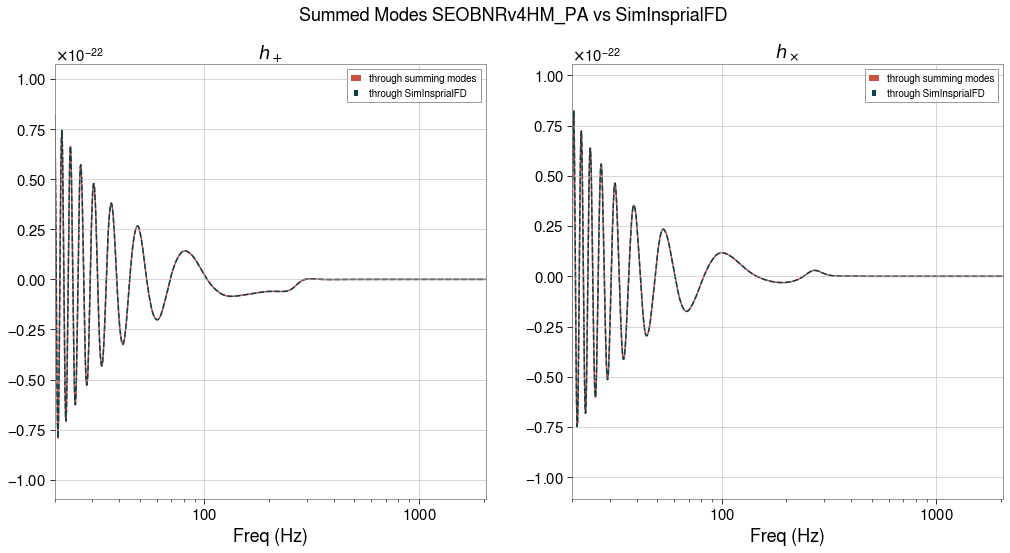

In [18]:
# Generating waveform in Frequency Domain, this is essentially SimInpsiralFD called on the waveform
pol_ref = wfg.generate_hplus_hcross(ref_parameters)

# Fourier transforming the time domain modes
freqs = np.concatenate((-domain()[::-1], domain()[1:]), axis=0)
hlm_fd = wfg_utils.td_modes_to_fd_modes(hlm_td, domain)
pol_m = wfg_utils.get_polarizations_from_fd_modes_m(hlm_fd, iota, parameters["phase"])
pol = waveform_generator.sum_contributions_m(pol_m, phase_shift=phase_shift)

fig, axes = plt.subplots(1, 2, figsize=(17, 8))
fig.suptitle(r"Summed Modes SEOBNRv4HM_PA vs SimInsprialFD")

axes[0].set_xscale('log')
axes[0].set_xlim([20, 2048])
axes[0].set_title(r"$h_+$")
axes[0].set_xlabel("Freq (Hz)")
axes[0].plot(domain.sample_frequencies, pol["h_plus"], label="through summing modes")
axes[0].plot(domain.sample_frequencies, pol_ref["h_plus"], linestyle='--', label="through SimInsprialFD")
axes[0].legend()

axes[1].set_xscale('log')
axes[1].set_xlim([20, 2048])
axes[1].set_title(r"$h_\times$")
axes[1].set_xlabel("Freq (Hz)")
axes[1].plot(domain.sample_frequencies, pol["h_cross"], label="through summing modes")
axes[1].plot(domain.sample_frequencies, pol_ref["h_cross"], linestyle='--', label="through SimInsprialFD")
axes[1].legend()

mismatches = [get_mismatch(pol[pol_name], pol_ref[pol_name], wfg.domain) for pol_name in pol]
print(f"Mismatch of {mismatches}")